In [1]:
from __future__ import print_function, division
%matplotlib inline  
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import itertools
import functools
import copy
import Bio
import Bio.Alphabet.IUPAC as IUPAC
import toolz.dicttoolz as dicttoolz

In [2]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s.%(msecs).03d %(name)s %(message)s",
    datefmt='%Y-%m-%dT%H:%M:%S'
)

from itertools import product, izip, chain
def dict_product(iterable_dict):
    return (dict(izip(iterable_dict, x)) for x in product(*iterable_dict.itervalues()))

def model_predictions(protease, train_data, parameters):
    from sklearn.metrics import mean_squared_error
    import protease_experimental_analysis.sequence_protease_susceptibility as sequence_protease_susceptibility
    import data_constk_161218_rd1234


    ssm_data = pd.DataFrame.from_dict({
        "sequence" : map(str.strip, open('160924_grocklin_ssm2_myseqs').readlines())
    })

    ssm_data["pred_sequence"] = ["GGGSASHM" + x + "LEGGGSEQ" + ('Z' * (46 - len(x))) for x in ssm_data.sequence.values]
    bigtable_prot=pd.read_csv('big_ssm2_nextseq_table_known_frac_named',delim_whitespace=True,header=None)
    bigtable_prot=bigtable_prot[[0,1]]
    bigtable_prot.columns=['name','sequence']
    ssm=pd.merge(left=bigtable_prot, right=ssm_data,on='sequence',how='inner')

    if train_data == 'all':
        scramble_data = data_constk_161218_rd1234.scramble_data
    elif train_data == 'rd1':
        scramble_data = data_constk_161218_rd1234.rd1_scramble_data
    
    
    full_data = data_constk_161218_rd1234.full_df
    full_data=full_data.query('protease == "%s"' % protease)
    full_data["full_sequence"] = "GGGSASHM" + full_data["sequence"] + "LEGGGSEQ"
    max_len=max([len(x) for x in full_data["full_sequence"].values])
    full_data["full_sequence"] = [old_seq + ('Z' * (max_len - len(old_seq))) for old_seq in full_data["full_sequence"].values]
    
    
    data = scramble_data.query("round != 'pdb' and protease == '%s'" % protease)
    
    
    model = sequence_protease_susceptibility.CenterLimitedPSSMModel(**dict(parameters))
    model.fit(list(data["full_sequence"].values), data["ec50"].values)
    data["fit_pred_ec50"] = model.predict(list(data["full_sequence"].values))
    
    ssm_preds = model.predict(list(ssm['pred_sequence']))
    full_data_preds = model.predict(list(full_data['full_sequence']))
    
    
    extras = {}
    extras['ssm_pred'] = ssm_preds
    extras['full_data_pred'] = full_data_preds
    extras['mse'] = mean_squared_error(data["fit_pred_ec50"].values,data["ec50"].values)
    extras['fit_coeffs_'] = model.fit_coeffs_
    
    return {'train_output': data, 'extras': extras}

param_space = {
    "alpha_center" : np.exp(np.array([-15])), #essentially no regularization applied
    "alpha_flank" : np.exp(np.array([-15])), #essentially no regularization applied
    "max_data_upweight" : (1.0,),
    "init_EC50_max" : (20,),
    "init_k_max" : (10,),
    "error_upper_lim": (10,),
    "flanking_window": (4,),
}

proteases = ["tryp","chymo"]
train_data = ['all']
parameter_sets = [frozenset(d.items()) for d in dict_product(param_space)]


In [3]:
model_results={}
for protease in proteases:
    model_results[protease]= model_predictions(protease, 'all', parameter_sets[0])

rd1_tryp.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput tryp 1 8152 8152
rd2_merge_tryp.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput tryp 2 3923 3923
rd3_merge_tryp.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput tryp 3 4158 4158
rd4_tryp.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput tryp 4 5202 8692
rd1_chymo.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput chymo 1 8443 8443
rd2_merge_chymo.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput chymo 2 4244 4244
rd3_merge_chymo.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput chymo 3 4158 4158
rd4_chymo.sel_k0.8.erf.5e-7.0.0001.3cycles.fulloutput chymo 4 5202 8676
114049
113982


/Users/grocklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/grocklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
ERROR (theano.gof.opt): Optimization failure due to: local_upcast_elemwise_constant_inputs
2017-04-30T17:58:55.895 theano.gof.opt Optimization failure due to: local_upcast_elemwise_constant_inputs
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{log,no_inplace}.0, TensorConstant{

In [4]:
from scipy.cluster.hierarchy import ward, complete, dendrogram
from scipy.spatial.distance import pdist
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib import gridspec
from scipy.stats import gaussian_kde
def kde_peak(x):
    gk = gaussian_kde(x)
    gk_out=zip(gk.evaluate(np.linspace(min(x),max(x),5000)),np.linspace(min(x),max(x),5000) )
    gk_out.sort()
    gk_out.reverse()
    return gk_out[0][1]

def cluster_heatmap2(fit_coeffs_,title='',vrange=[None,None]):
    sns.set_style('white')
    sns.set(font_scale=1.0)
    coeffs=copy.deepcopy(fit_coeffs_["outer_PSSM"][:,[i for i in range(20) if i != 1]])
    
    
    
    
    for i in range(len(coeffs)):
        coeffs[i,:] = coeffs[i,:] - kde_peak(coeffs[i,:])
    

    labels=[IUPAC.IUPACProtein.letters[i] for i in range(20) if i != 1]   # + 'Z'
    coeffs_for_clustering=copy.deepcopy(coeffs)
    coeffs_for_clustering[4,:] = [fit_coeffs_["P1_PSSM"][i] for i in range(20) if i != 1]
    dmat = pdist(coeffs_for_clustering.T)
    clusters = complete(dmat)

    plt.figure(figsize=(4.5,2.5))
    plt.suptitle(title)

    
    
    gs = gridspec.GridSpec(7, 1,
                       height_ratios=[0.12,0.065,0.4,0.01,0.1,0.01,0.4]
                       )
    
    
    mysym = SymLogNorm(linthresh = 3, linscale=1.0,vmin=vrange[0], vmax=vrange[1])
    ax1=plt.subplot(gs[0])
    with plt.rc_context({'lines.linewidth': 0.5, 'xtick.major.pad': 0}):
        dendro = dendrogram(clusters,labels=labels,
                            leaf_font_size=10,leaf_rotation=0,
                            link_color_func = lambda x: 'black', distance_sort='ascending')
    ax1.tick_params(axis='both', which='major', pad=2)
    plt.yticks([])
    ax1.set_axis_bgcolor('white')
    for t in ['left','right','top','bottom']:
        ax1.spines[t].set_visible(False)
    coeffs=coeffs[:,dendro['leaves']]
    ax2=plt.subplot(gs[2])
    sns.heatmap(coeffs[0:4,:],cbar=False,xticklabels=['' for x in range(20)],
               yticklabels="P5 P4 P3 P2".split(),annot=True,fmt='.1f',annot_kws={"size": 7}, vmin=vrange[0], vmax=vrange[1],
               norm=mysym)
    ax2.tick_params(axis='both', which='major', pad=2)
    
    ax3=plt.subplot(gs[6])
    sns.heatmap(coeffs[-4:,:],xticklabels=[labels[t] for t in dendro['leaves']],cbar=False,
               yticklabels="P1' P2' P3' P4'".split(),annot=True,fmt='.1f',annot_kws={"size": 7}, vmin=vrange[0], vmax=vrange[1],
               norm=mysym)
    ax3.tick_params(axis='both', which='major', pad=2)
    
    
    ax4=plt.subplot(gs[4])
    p1coeffs=np.reshape(fit_coeffs_["P1_PSSM"][0:20],(1,20))
    p1coeffs = p1coeffs[:,[i for i in range(20) if i != 1]]
    p1coeffs=p1coeffs[:,dendro['leaves']]
    #print (p1coeffs)
    p1coeffs = p1coeffs - kde_peak(p1coeffs[0])
    sns.heatmap(p1coeffs,cbar=False,xticklabels=['' for x in range(20)],
               yticklabels=["P1"],annot=True,fmt='.1f',annot_kws={"size": 7}, vmin=vrange[0], vmax=vrange[1],
               norm=mysym)
    plt.yticks(rotation=0) 
    ax4.tick_params(axis='both', which='major', pad=2)
    
    
    plt.subplots_adjust(hspace=0.1,left=0.05,right=0.99,top=0.99,bottom=0.09,wspace=0)

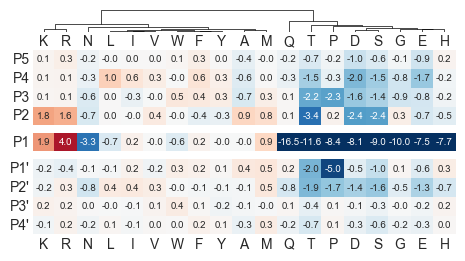

In [5]:
cluster_heatmap2(model_results['tryp']['extras']['fit_coeffs_'],vrange=[-6,4])

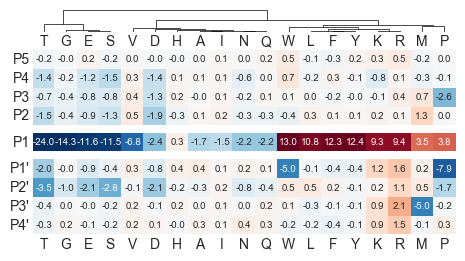

In [6]:
cluster_heatmap2(model_results['chymo']['extras']['fit_coeffs_'],vrange=[-8,13])

In [7]:
import data_constk_161218_rd1234
full_data = data_constk_161218_rd1234.full_df
full_data["full_sequence"] = "GGGSASHM" + full_data["sequence"] + "LEGGGSEQ"
max_len=max([len(x) for x in full_data["full_sequence"].values])
full_data["full_sequence"] = [old_seq + ('Z' * (max_len - len(old_seq))) for old_seq in full_data["full_sequence"].values]


full_data_byprot = {
    t : full_data[full_data["protease"] == t]
    for t in ("chymo", "tryp")
}

for protease in ['tryp','chymo']:
    full_data_byprot[protease]['ec50_pred'] = model_results[protease]['extras']['full_data_pred']
    full_data_byprot[protease]['ec50_rise'] = full_data_byprot[protease]['ec50'] - full_data_byprot[protease]['ec50_pred']
    full_data_byprot[protease].to_csv('regenerate_ec50_pred_%s.csv' % protease,index=False)

/Users/grocklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/grocklin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
ssm_data = pd.DataFrame.from_dict({
    "sequence" : map(str.strip, open('160924_grocklin_ssm2_myseqs').readlines())
})

ssm_data["pred_sequence"] = ["GGGSASHM" + x + "LEGGGSEQ" + ('Z' * (46 - len(x))) for x in ssm_data.sequence.values]
bigtable_prot=pd.read_csv('big_ssm2_nextseq_table_known_frac_named',delim_whitespace=True,header=None)
bigtable_prot=bigtable_prot[[0,1]]
bigtable_prot.columns=['name','sequence']
ssm_data=pd.merge(left=bigtable_prot, right=ssm_data,on='sequence',how='inner')


#Note: these predicted EC50s are in the units of the Round 1-4 sorts which included
#the scrambled sequences, and are not not in the same units as the reported SSM EC50s due
#to the different protease concentrations used. Thsee have to be converted from "model units"
#into the SSM units shown in the file ssm2_stability_scores.
ssm_data['ec50_pred_t'] = model_results['tryp']['extras']['ssm_pred']
ssm_data['ec50_pred_c'] = model_results['chymo']['extras']['ssm_pred']

#Convert to the SSM units: each sort is now a factor of 2 in protease concentration instead of
#a factor of 3, and all the sorts are at higher protease concentration.
#
# An EC50 of "1" corresponds to:
#               Model_Units          SSM_Units
#  Trypsin     52 uM / 729          52 uM / 128
#  Chymotryp   20 uM / 243          27 uM / 128
#
#               Model_Units          SSM_Units
#  Trypsin     0.07133059 uM         0.40625 uM 
#  Chymotryp   0.08230453 uM       0.2109375 uM
#
#  The constants below can be calculated:
#  3.09474 = np.log2(0.40625/(0.07133059/3.0)) - 1
#  1.94273 = np.log2(0.2109375/(0.08230453/3.0)) - 1
ssm_data['ec50_pred_ssm_units_t'] = np.log2(3.0 ** ssm_data['ec50_pred_t'].values)-3.09474
ssm_data['ec50_pred_ssm_units_c'] = np.log2(3.0 ** ssm_data['ec50_pred_c'].values)-1.94273

ssm_data.to_csv('regenerate_ssm_ec50_pred.csv',index=False)

In [9]:
out_table = []
aa_nums = range(20)
aa_nums.remove(1)
aas = [x for x in 'ADEFGHIKLMNPQRSTVWY']
full_prot_names={'tryp': 'trypsin','chymo': 'chymotrypsin'}

for protease in ['tryp','chymo']:
    fc = model_results[protease]['extras']['fit_coeffs_']
    rows = [x for x in fc['outer_PSSM'][0:4]]
    rows.append(fc['P1_PSSM'])
    rows += [x for x in fc['outer_PSSM'][5:]]
    row_names = ['P5','P4','P3','P2','P1',"P1'","P2'","P3'","P4'"]
    for row, row_name in zip(rows, row_names):
        for aa_num, aa in zip(aa_nums, aas):
            out_table.append((full_prot_names[protease], row_name, aa, row[aa_num]))
    out_table.append((full_prot_names[protease], 'EC50_max','',fc['EC50_max']))
    out_table.append((full_prot_names[protease], 'c0','',fc['c0']))
    out_table.append((full_prot_names[protease], 'k_max','',fc['k_max']))

out_table=pd.DataFrame(out_table)
out_table.columns=['protease','variable','aa','value']
out_table.to_csv('regenerate_unfolded_state_model_params',index=False,sep='\t')